In [1]:
import os
import glob
import json
import yaml
import numpy as np
import torch
import argparse

import sys
from pathlib import Path
abs_path = str(Path.cwd().parents[0].absolute())
sys.path+=[abs_path, f'{abs_path}/utils']
from evaluation import Options, Trainer

from utils import ICT_face_model, YamlArgParser
from utils.matplotlib_rnd import (
    render_mesh_diff,
    plot_image_array
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
## load checkpoint from originial NFR

ckpt = '' ## dummy ckpt
design='nfr'
dec_type = 'jacob'

config = f'{abs_path}/config/train.yml'
opts_yaml = yaml.load(open(config), Loader=yaml.FullLoader)
opts = argparse.Namespace(**opts_yaml)

opts.NFR = True
opts.dec_type = 'jacob'
opts.ckpt = '' ## ------> dummy ckpt
opts.design = 'nfr'

opts.device="cuda:0"

opts.data_rand_trans=False
opts.data_rand_scale=False
opts.learn_rig_emb=False
opts.use_decimate = False
opts.stage1 = True
opts.stage2 = False
opts.stage22 = False
opts.scale_exp = 1.0
opts.load_rigformer = False

trainer = Trainer(opts)

Loading... pretrained NFR


(11248, 3)


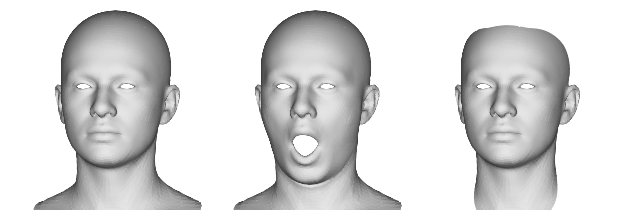

In [3]:
## full head
ict_face_model = ICT_face_model(face_only=False)
ict_tri, _ = ict_face_model.get_mesh()

## face only
ict_face_model_fo = ICT_face_model(face_only=True)
ict_tri_fo, _ = ict_face_model_fo.get_mesh()


## ICT random expression
bs_coeff = np.eye(53)[26]
vertices = torch.from_numpy(ict_tri.vertices + ict_face_model.get_exp_disp(bs_coeff))
src_mesh = ict_tri
tgt_mesh = ict_tri_fo


print(ict_tri.vertices.shape)

M_SCALE = 0.68
v_list=[ ict_tri.vertices * M_SCALE, vertices[0] * M_SCALE, ict_tri_fo.vertices * M_SCALE ]
f_list=[ ict_tri.faces, ict_tri.faces, ict_tri_fo.faces ]
SIZE=2

plot_image_array(
    v_list, f_list,
    rot_list=[[0,-10,0]]*len(v_list), 
    size=SIZE, bg_black=False, mode='shade', 
    logdir=f"_tmp/train", 
    name=f"test", save=False
)

In [4]:
print(bs_coeff.shape)
print(vertices.shape)
print(ict_tri.vertices.shape)

(53,)
torch.Size([1, 11248, 3])
(11248, 3)


In [5]:
pred_outputs = trainer.model.inference(
    vertices=vertices, 
    src_mesh=src_mesh, 
    tgt_mesh=tgt_mesh
)

100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


 source neutral 	|	 source expression 	|	 target neutral 	|	 target expression


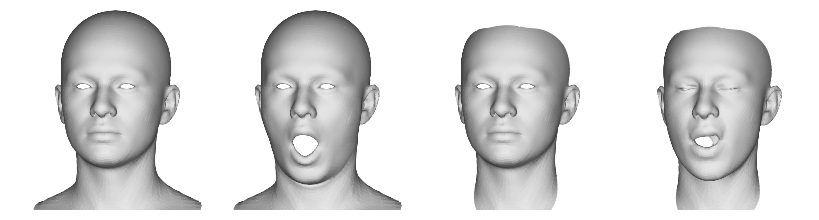

In [7]:
v_list=[ ict_tri.vertices * M_SCALE, vertices[0] * M_SCALE, ict_tri_fo.vertices * M_SCALE, pred_outputs.detach().cpu().numpy()[0] * M_SCALE ]
f_list=[ ict_tri.faces, ict_tri.faces, ict_tri_fo.faces, ict_tri_fo.faces ]

print(' source neutral \t|\t source expression \t|\t target neutral \t|\t target expression')
plot_image_array(
    v_list, f_list,
    rot_list=[[0,-10,0]]*len(v_list), 
    size=SIZE, bg_black=False, mode='shade', 
    logdir=f"_tmp/train", 
    name=f"test", save=False
)